你被要求：
- 尝试使用你所学到的知识，如动态规划等，尽可能的在多臂老虎机中得到更高的分数（200次累计交互）
- 学习贝尔曼方程，使用贝尔曼方程解决上述问题。

首先使用题目给出的随机策略，查看基于随机策略的结果：

学习：重新复习了鱼书4-强化学习、特别时贝尔曼方程、贝尔曼最优方程及推导部分

随机生成了一个10臂伯努利老虎机
获得概率最大的拉杆为6号，其获奖概率为0.8974


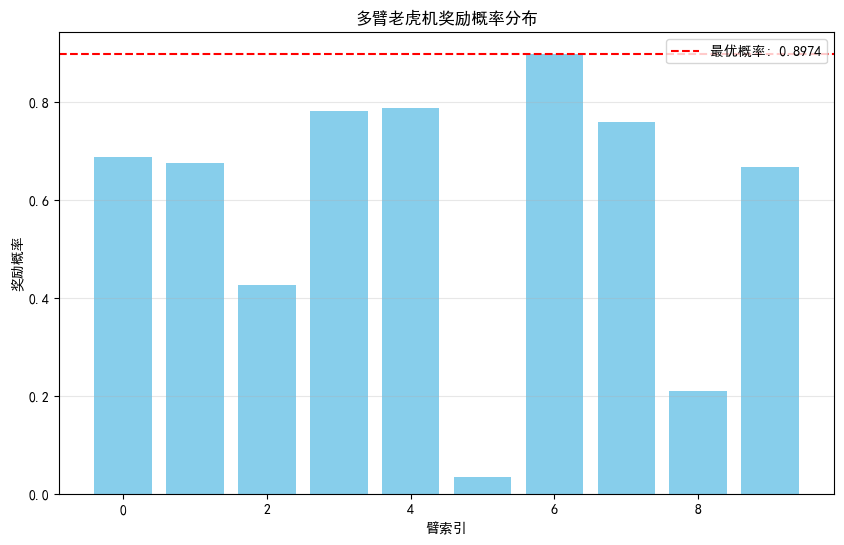


模拟随机选择策略...

累积奖励: 139.0
累积遗憾: 40.48
每个臂的选择次数: [26 20 22 18 24 13 11 27  9 30]
每个臂的平均奖励: [0.6154 0.6    0.5    0.8333 1.     0.     1.     0.8519 0.3333 0.8   ]


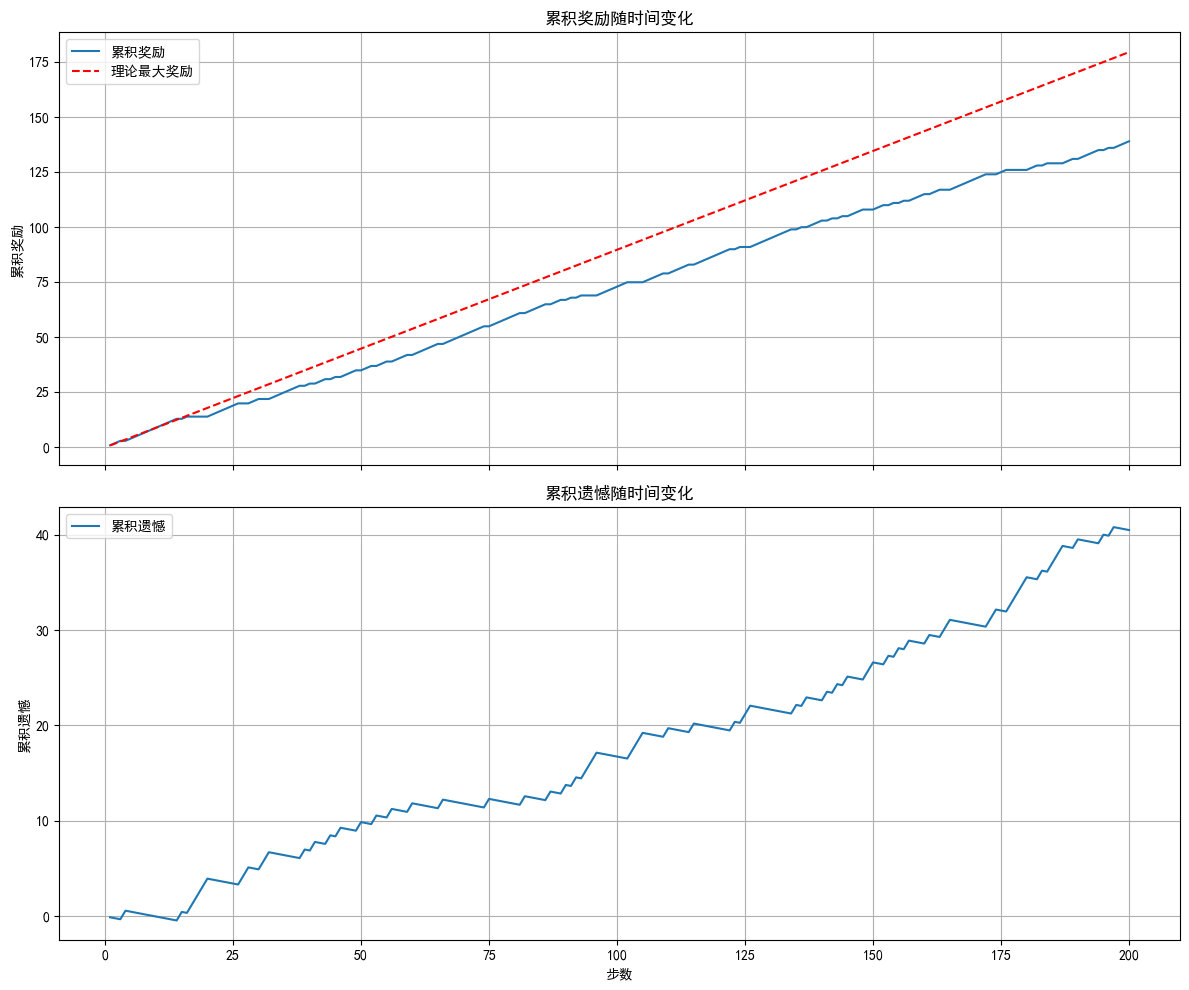

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False

class BernoulliBandit:
    """
    伯努利多臂老虎机
    
    参数:
        K (int): 老虎机的臂(拉杆)数量
        seed (int, optional): 随机种子，用于结果复现
    
    属性:
        probs (np.ndarray): 每个臂的奖励概率(0-1之间的值)
        best_idx (int): 最优臂的索引
        best_prob (float): 最优臂的奖励概率
        K (int): 臂的数量
        counts (np.ndarray): 每个臂被选择的次数
        values (np.ndarray): 每个臂的平均奖励值
        cumulative_regret (float): 累积遗憾
        cumulative_reward (float): 累积奖励
        history (list): 历史选择记录(臂索引, 奖励)
    """
    
    def __init__(self, K, seed=None):
        """
        初始化伯努利多臂老虎机
        
        参数:
            K (int): 臂的数量
            seed (int, optional): 随机种子
        """
        if seed is not None:
            np.random.seed(seed)
            
        self.probs = np.random.uniform(size=K)       # 随机生成K个0~1的数，作为拉动每根拉杆的获得奖励的概率
        self.best_idx = np.argmax(self.probs)        # 获奖概率最大的拉杆索引
        self.best_prob = self.probs[self.best_idx]   # 最大的奖励概率
        self.K = K
        
        # 初始化统计信息
        self.counts = np.zeros(K, dtype=int)         # 每个臂被选择的次数
        self.values = np.zeros(K)                    # 每个臂的平均奖励值
        self.cumulative_regret = 0.0                # 累积遗憾
        self.cumulative_reward = 0.0                # 累积奖励
        self.history = []                            # 历史选择记录(臂索引, 奖励)
    
    def step(self, k):
        """
        选择指定的臂并返回奖励
        
        参数:
            k (int): 选择的臂索引(0到K-1)
        
        返回:
            reward (int): 奖励值(0或1)
        """
        # 检查输入有效性
        if k < 0 or k >= self.K:
            raise ValueError(f"臂索引{k}超出范围(0-{self.K-1})")
            
        # 生成奖励(伯努利试验)
        reward = 1 if np.random.rand() < self.probs[k] else 0
        
        # 更新统计信息
        self.counts[k] += 1
        # 使用增量公式更新平均值: new_avg = old_avg + (reward - old_avg) / count
        self.values[k] += (reward - self.values[k]) / self.counts[k]
        
        # 更新累积奖励和遗憾
        self.cumulative_reward += reward
        self.cumulative_regret += self.best_prob - reward
        
        # 记录历史
        self.history.append((k, reward))
        
        return reward
    
    def reset_stats(self):
        """重置所有统计信息(保持概率分布不变)"""
        self.counts = np.zeros(self.K, dtype=int)
        self.values = np.zeros(self.K)
        self.cumulative_regret = 0.0
        self.cumulative_reward = 0.0
        self.history = []
    
    def plot_probabilities(self):
        """可视化每个臂的奖励概率"""
        plt.figure(figsize=(10, 6))
        plt.bar(range(self.K), self.probs, color='skyblue')
        plt.axhline(y=self.best_prob, color='r', linestyle='--', label=f'最优概率: {self.best_prob:.4f}')
        plt.xlabel('臂索引')
        plt.ylabel('奖励概率')
        plt.title('多臂老虎机奖励概率分布')
        plt.legend()
        plt.grid(True, axis='y', alpha=0.3)
        plt.show()
    
    def plot_performance(self):
        """可视化老虎机的性能指标"""
        if not self.history:
            print("没有历史数据可供绘图")
            return
            
        # 准备数据
        steps = np.arange(1, len(self.history) + 1)
        rewards = np.array([r for _, r in self.history])
        cumulative_rewards = np.cumsum(rewards)
        cumulative_regrets = np.cumsum([self.best_prob - r for r in rewards])
        
        # 创建图表
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
        
        # 累积奖励图
        ax1.plot(steps, cumulative_rewards, label='累积奖励')
        ax1.plot(steps, self.best_prob * steps, 'r--', label='理论最大奖励')
        ax1.set_title('累积奖励随时间变化')
        ax1.set_ylabel('累积奖励')
        ax1.legend()
        ax1.grid(True)
        
        # 累积遗憾图
        ax2.plot(steps, cumulative_regrets, label='累积遗憾')
        ax2.set_title('累积遗憾随时间变化')
        ax2.set_xlabel('步数')
        ax2.set_ylabel('累积遗憾')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def __str__(self):
        """返回老虎机的字符串表示"""
        return (f"BernoulliBandit(K={self.K}, best_arm={self.best_idx}, "
                f"best_prob={self.best_prob:.4f})")

# 测试代码
if __name__ == "__main__":
    np.random.seed(114514)
    K = 10
    bandit = BernoulliBandit(K)
    print("随机生成了一个10臂伯努利老虎机")
    print(f"获得概率最大的拉杆为{bandit.best_idx}号，其获奖概率为{bandit.best_prob:.4f}")
    
    # 可视化概率分布
    bandit.plot_probabilities()
    
    # 模拟随机选择策略，用于了解环境运行，交互次数为200次，累计奖励
    print("\n模拟随机选择策略...")
    for _ in range(200):
        arm = np.random.randint(K)  # 随机选择一个臂
        reward = bandit.step(arm)
    
    #====================================#
    #你的代码，需将前面的随机策略注释
    # print("\n我的选择策略：每次选择当前平均奖励最高的臂")
    #====================================#
    
    
    # 输出统计信息
    print(f"\n累积奖励: {bandit.cumulative_reward}")
    print(f"累积遗憾: {bandit.cumulative_regret:.2f}")
    print(f"每个臂的选择次数: {bandit.counts}")
    print(f"每个臂的平均奖励: {np.round(bandit.values, 4)}")
    
    # 可视化性能
    bandit.plot_performance()

显然随机策略最终的结果应当约等于总的奖励期望，因为每个臂被选择的概率应当是相等的，实际结果有差异是因为200个样本数量偏少  将随机策略改为最基础的epicilion-greedy策略：

随机生成了一个10臂伯努利老虎机
获得概率最大的拉杆为6号，其获奖概率为0.8974


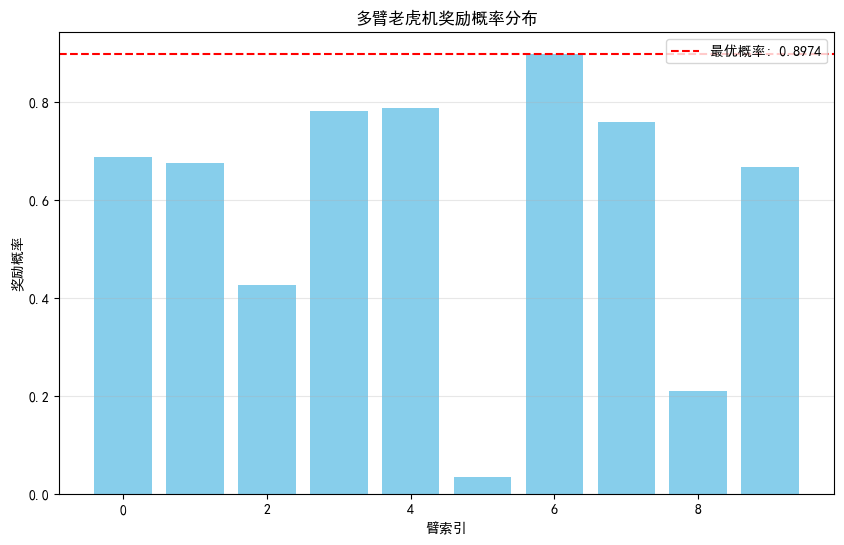


累积奖励: 149.0
累积遗憾: 30.48
每个臂的选择次数: [ 20   0   3   3   3   1  29 106   1  34]
每个臂的平均奖励: [0.65   0.     0.6667 0.6667 0.6667 0.     0.9655 0.7358 0.     0.7059]


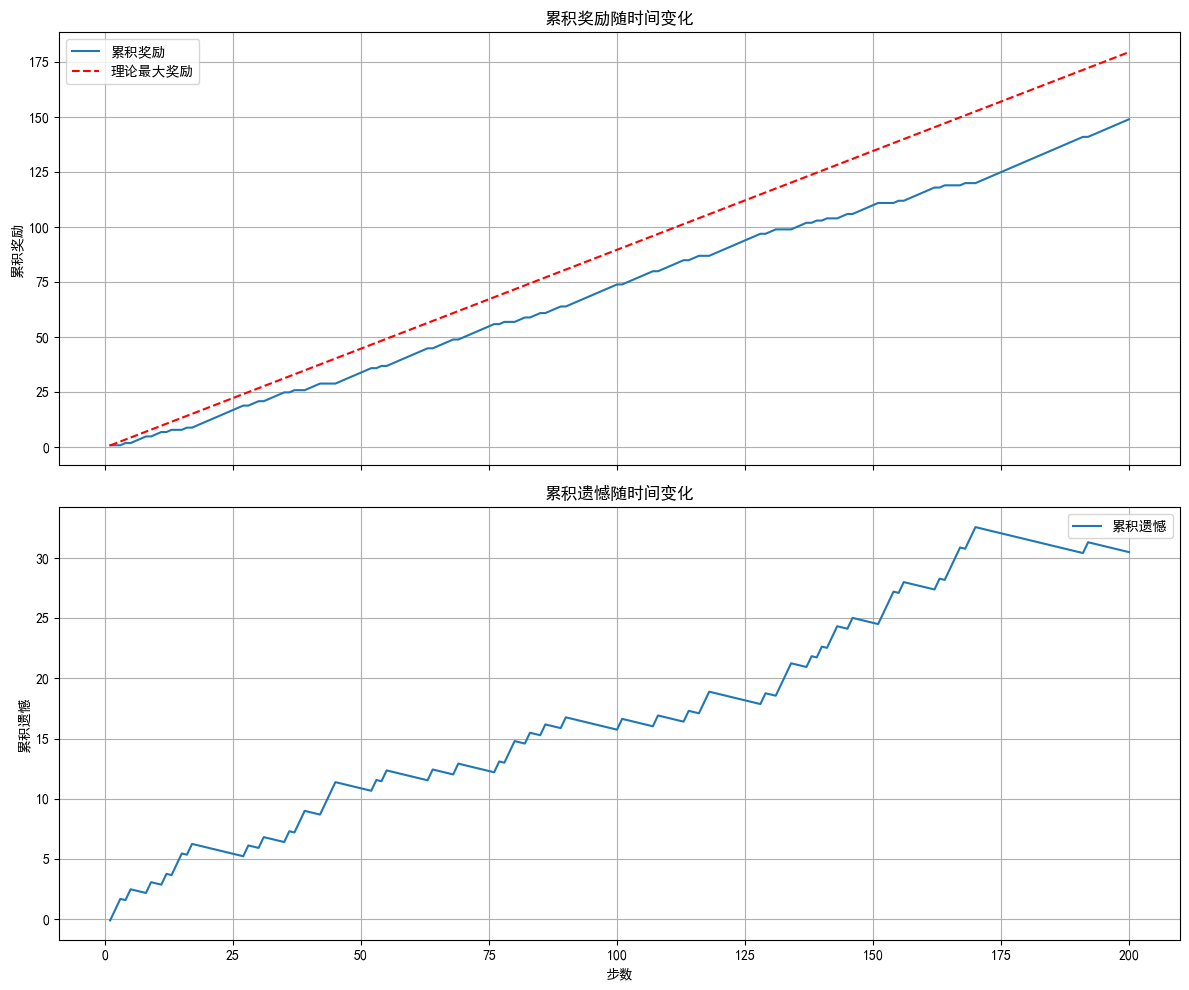

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False

class BernoulliBandit:
    """
    伯努利多臂老虎机
    
    参数:
        K (int): 老虎机的臂(拉杆)数量
        seed (int, optional): 随机种子，用于结果复现
    
    属性:
        probs (np.ndarray): 每个臂的奖励概率(0-1之间的值)
        best_idx (int): 最优臂的索引
        best_prob (float): 最优臂的奖励概率
        K (int): 臂的数量
        counts (np.ndarray): 每个臂被选择的次数
        values (np.ndarray): 每个臂的平均奖励值
        cumulative_regret (float): 累积遗憾
        cumulative_reward (float): 累积奖励
        history (list): 历史选择记录(臂索引, 奖励)
    """
    
    def __init__(self, K, seed=None):
        """
        初始化伯努利多臂老虎机
        
        参数:
            K (int): 臂的数量
            seed (int, optional): 随机种子
        """
        if seed is not None:
            np.random.seed(seed)
            
        self.probs = np.random.uniform(size=K)       # 随机生成K个0~1的数，作为拉动每根拉杆的获得奖励的概率
        self.best_idx = np.argmax(self.probs)        # 获奖概率最大的拉杆索引
        self.best_prob = self.probs[self.best_idx]   # 最大的奖励概率
        self.K = K
        
        # 初始化统计信息
        self.counts = np.zeros(K, dtype=int)         # 每个臂被选择的次数
        self.values = np.zeros(K)                    # 每个臂的平均奖励值
        self.cumulative_regret = 0.0                # 累积遗憾
        self.cumulative_reward = 0.0                # 累积奖励
        self.history = []                            # 历史选择记录(臂索引, 奖励)
    
    def step(self, k):
        """
        选择指定的臂并返回奖励
        
        参数:
            k (int): 选择的臂索引(0到K-1)
        
        返回:
            reward (int): 奖励值(0或1)
        """
        # 检查输入有效性
        if k < 0 or k >= self.K:
            raise ValueError(f"臂索引{k}超出范围(0-{self.K-1})")
            
        # 生成奖励(伯努利试验)
        reward = 1 if np.random.rand() < self.probs[k] else 0
        
        # 更新统计信息
        self.counts[k] += 1
        # 使用增量公式更新平均值: new_avg = old_avg + (reward - old_avg) / count
        self.values[k] += (reward - self.values[k]) / self.counts[k]
        
        # 更新累积奖励和遗憾
        self.cumulative_reward += reward
        self.cumulative_regret += self.best_prob - reward
        
        # 记录历史
        self.history.append((k, reward))

        
        return reward
    
    def reset_stats(self):
        """重置所有统计信息(保持概率分布不变)"""
        self.counts = np.zeros(self.K, dtype=int)
        self.values = np.zeros(self.K)
        self.cumulative_regret = 0.0
        self.cumulative_reward = 0.0
        self.history = []
    
    def plot_probabilities(self):
        """可视化每个臂的奖励概率"""
        plt.figure(figsize=(10, 6))
        plt.bar(range(self.K), self.probs, color='skyblue')
        plt.axhline(y=self.best_prob, color='r', linestyle='--', label=f'最优概率: {self.best_prob:.4f}')
        plt.xlabel('臂索引')
        plt.ylabel('奖励概率')
        plt.title('多臂老虎机奖励概率分布')
        plt.legend()
        plt.grid(True, axis='y', alpha=0.3)
        plt.show()
    
    def plot_performance(self):
        """可视化老虎机的性能指标"""
        if not self.history:
            print("没有历史数据可供绘图")
            return
            
        # 准备数据
        steps = np.arange(1, len(self.history) + 1)
        rewards = np.array([r for _, r in self.history])
        cumulative_rewards = np.cumsum(rewards)
        cumulative_regrets = np.cumsum([self.best_prob - r for r in rewards])
        
        # 创建图表
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
        
        # 累积奖励图
        ax1.plot(steps, cumulative_rewards, label='累积奖励')
        ax1.plot(steps, self.best_prob * steps, 'r--', label='理论最大奖励')
        ax1.set_title('累积奖励随时间变化')
        ax1.set_ylabel('累积奖励')
        ax1.legend()
        ax1.grid(True)
        
        # 累积遗憾图
        ax2.plot(steps, cumulative_regrets, label='累积遗憾')
        ax2.set_title('累积遗憾随时间变化')
        ax2.set_xlabel('步数')
        ax2.set_ylabel('累积遗憾')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def __str__(self):
        """返回老虎机的字符串表示"""
        return (f"BernoulliBandit(K={self.K}, best_arm={self.best_idx}, "
                f"best_prob={self.best_prob:.4f})")

# 测试代码
if __name__ == "__main__":
    np.random.seed(114514)
    K = 10
    bandit = BernoulliBandit(K)
    print("随机生成了一个10臂伯努利老虎机")
    print(f"获得概率最大的拉杆为{bandit.best_idx}号，其获奖概率为{bandit.best_prob:.4f}")
    
    # 可视化概率分布
    bandit.plot_probabilities()
    
    # 模拟随机选择策略，用于了解环境运行，交互次数为200次，累计奖励
    # print("\n模拟随机选择策略...")
    # for _ in range(200):
    #     arm = np.random.randint(K)  # 随机选择一个臂
    #     reward = bandit.step(arm)
    
    #====================================#
    #你的代码，需将前面的随机策略注释
    bandit.reset_stats()  # 重置统计

    for i in range(200):
        # 10%概率探索，90%概率利用
        if np.random.random() < 0.1:
            arm = np.random.randint(K)  # 随机探索
        else:
            arm = np.argmax(bandit.values)  # 选择当前最好的
        
        reward = bandit.step(arm)
    #====================================#
    
    
    # 输出统计信息
    print(f"\n累积奖励: {bandit.cumulative_reward}")
    print(f"累积遗憾: {bandit.cumulative_regret:.2f}")
    print(f"每个臂的选择次数: {bandit.counts}")
    print(f"每个臂的平均奖励: {np.round(bandit.values, 4)}")
    
    # 可视化性能
    bandit.plot_performance()

结果有点提升但不多，可能是因为ε设置地不好，所以接下来使用简单的网格搜索，找一下是奖励期望最大的ε：

开始网格搜索寻找最优ε值...
测试 ε=0.01...
  ε=0.01: 平均奖励=141.0, 平均遗憾=38.5, 标准差=0.00
测试 ε=0.02...
  ε=0.02: 平均奖励=146.0, 平均遗憾=33.5, 标准差=0.00
测试 ε=0.03...
  ε=0.03: 平均奖励=147.0, 平均遗憾=32.5, 标准差=0.00
测试 ε=0.04...
  ε=0.04: 平均奖励=139.0, 平均遗憾=40.5, 标准差=0.00
测试 ε=0.05...
  ε=0.05: 平均奖励=145.0, 平均遗憾=34.5, 标准差=0.00
测试 ε=0.060000000000000005...
  ε=0.060000000000000005: 平均奖励=151.0, 平均遗憾=28.5, 标准差=0.00
测试 ε=0.06999999999999999...
  ε=0.06999999999999999: 平均奖励=149.0, 平均遗憾=30.5, 标准差=0.00
测试 ε=0.08...
  ε=0.08: 平均奖励=149.0, 平均遗憾=30.5, 标准差=0.00
测试 ε=0.09...
  ε=0.09: 平均奖励=149.0, 平均遗憾=30.5, 标准差=0.00
测试 ε=0.09999999999999999...
  ε=0.09999999999999999: 平均奖励=149.0, 平均遗憾=30.5, 标准差=0.00
测试 ε=0.11...
  ε=0.11: 平均奖励=150.0, 平均遗憾=29.5, 标准差=0.00
测试 ε=0.12...
  ε=0.12: 平均奖励=151.0, 平均遗憾=28.5, 标准差=0.00
测试 ε=0.13...
  ε=0.13: 平均奖励=151.0, 平均遗憾=28.5, 标准差=0.00
测试 ε=0.14...
  ε=0.14: 平均奖励=146.0, 平均遗憾=33.5, 标准差=0.00
测试 ε=0.15000000000000002...
  ε=0.15000000000000002: 平均奖励=151.0, 平均遗憾=28.5, 标准差=0.00
测试 ε=0.16...
  ε=0.16: 平均奖励=149.0, 平均

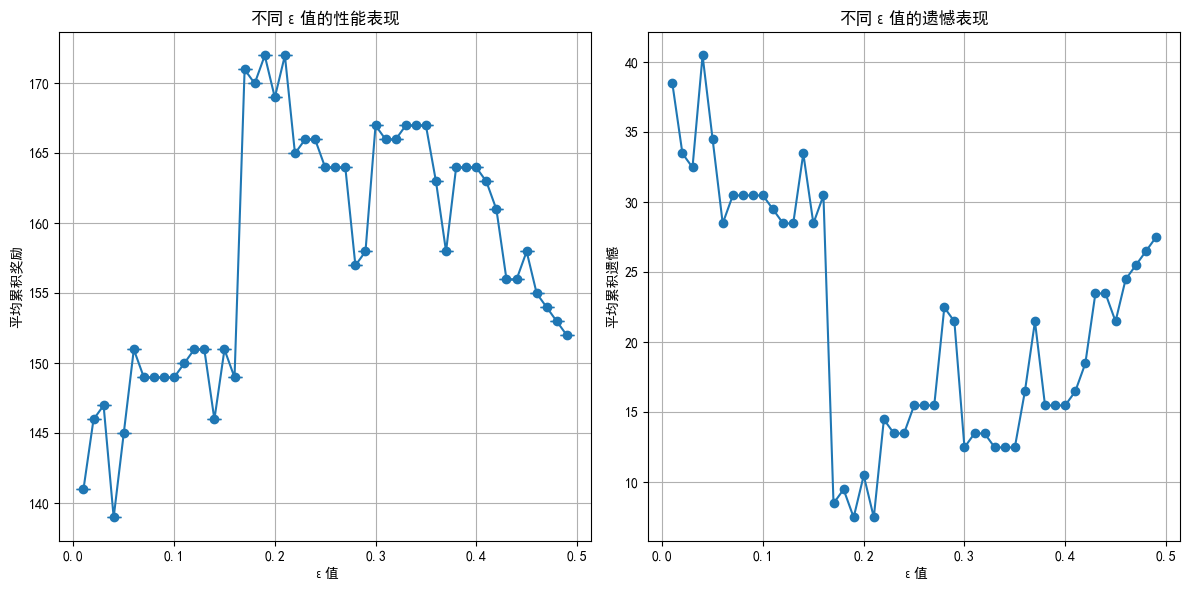

In [3]:
# 使用简单的网格搜索寻找最优的ε

def test_epsilon_greedy(bandit, epsilon, num_steps=200):
    """测试特定ε值的性能"""
    bandit_copy = BernoulliBandit(K, seed=114514)  # 创建新的老虎机实例，保持相同概率分布
    cumulative_rewards = []
    
    for i in range(num_steps):
        if np.random.random() < epsilon:
            arm = np.random.randint(bandit_copy.K)  # 探索
        else:
            arm = np.argmax(bandit_copy.values)  # 利用
        
        reward = bandit_copy.step(arm)
        cumulative_rewards.append(bandit_copy.cumulative_reward)
    
    return cumulative_rewards, bandit_copy.cumulative_reward, bandit_copy.cumulative_regret

# 定义要测试的ε值范围
epsilon_values=np.arange(0.01,0.5,0.01)
num_trials = 10  # 每个ε值重复试验次数，减少随机性影响

print("开始网格搜索寻找最优ε值...")

# 存储每个ε值的平均性能
results = {}

for epsilon in epsilon_values:
    total_reward = 0
    total_regret = 0
    all_final_rewards = []

    print(f"测试 ε={epsilon}...")
    
    for trial in range(num_trials):
        rewards, final_reward, final_regret = test_epsilon_greedy(bandit, epsilon)
        total_reward += final_reward
        total_regret += final_regret
        all_final_rewards.append(final_reward)
    
    # 计算平均性能
    avg_reward = total_reward / num_trials
    avg_regret = total_regret / num_trials
    std_reward = np.std(all_final_rewards)
    
    results[epsilon] = {
        'avg_reward': avg_reward,
        'avg_regret': avg_regret,
        'std_reward': std_reward
    }
    
    print(f"  ε={epsilon}: 平均奖励={avg_reward:.1f}, 平均遗憾={avg_regret:.1f}, 标准差={std_reward:.2f}")

# 找到最优的ε值
best_epsilon = max(results.items(), key=lambda x: x[1]['avg_reward'])[0]
best_result = results[best_epsilon]

print(f"\n网格搜索结果:")
print(f"最优ε值: {best_epsilon}")
print(f"对应平均奖励: {best_result['avg_reward']:.1f}")
print(f"对应平均遗憾: {best_result['avg_regret']:.1f}")

# 可视化结果
plt.figure(figsize=(12, 6))

# 绘制平均奖励随ε值变化
epsilons = list(results.keys())
avg_rewards = [results[eps]['avg_reward'] for eps in epsilons]
std_rewards = [results[eps]['std_reward'] for eps in epsilons]

plt.subplot(1, 2, 1)
plt.errorbar(epsilons, avg_rewards, yerr=std_rewards, fmt='o-', capsize=5)
plt.xlabel('ε值')
plt.ylabel('平均累积奖励')
plt.title('不同ε值的性能表现')
plt.grid(True)

# 绘制平均遗憾随ε值变化
avg_regrets = [results[eps]['avg_regret'] for eps in epsilons]
plt.subplot(1, 2, 2)
plt.plot(epsilons, avg_regrets, 'o-')
plt.xlabel('ε值')
plt.ylabel('平均累积遗憾')
plt.title('不同ε值的遗憾表现')
plt.grid(True)

plt.tight_layout()
plt.show()




当ε为0.19时平均奖励达到了172，有显著提升而且接近0.89*200的理想最优值，应该已经够用,但还是尝试一下应用更高级的方法，虽然懒得调参之类的

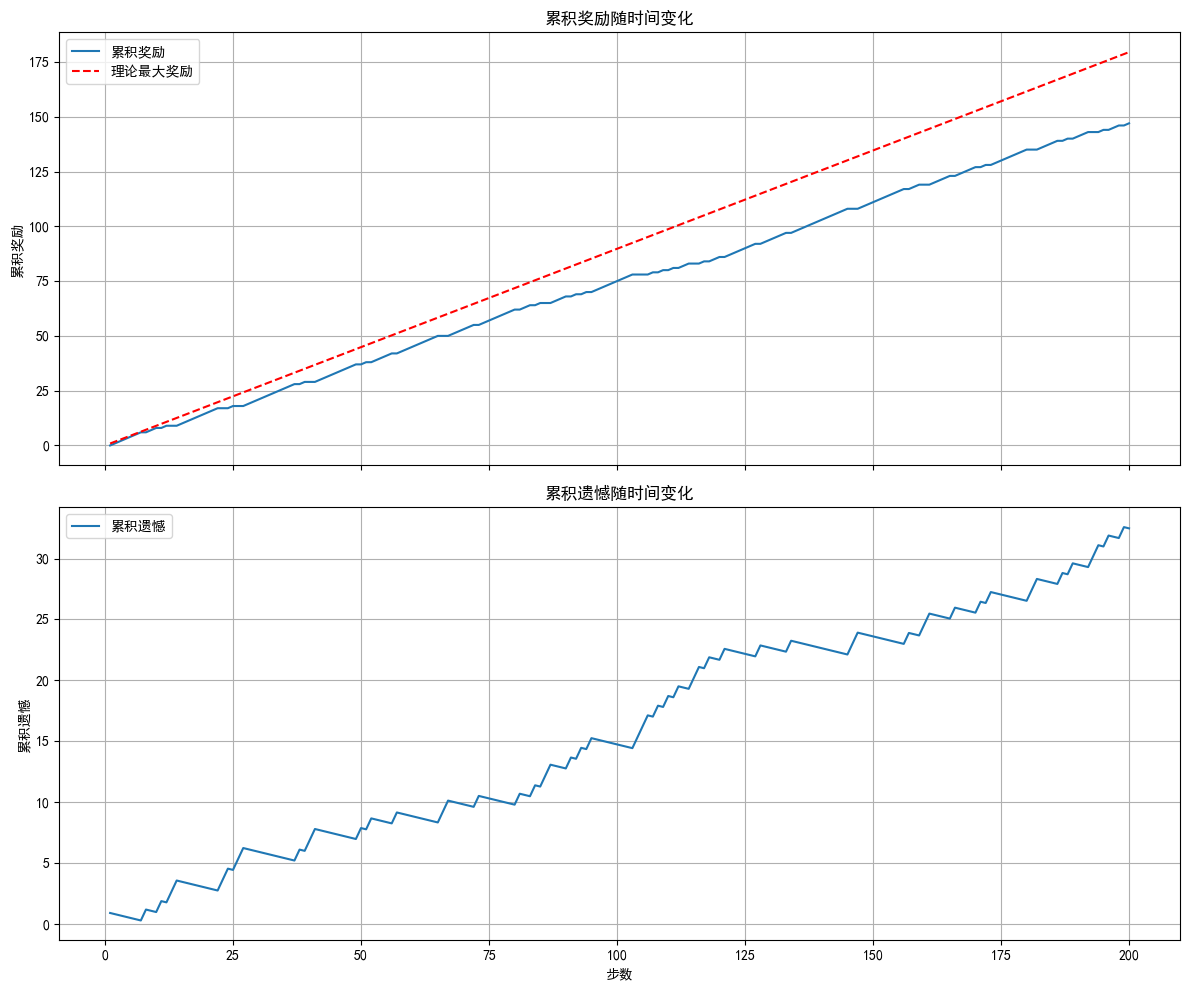


累积奖励: 147.0
累积遗憾: 32.48
每个臂的选择次数: [22 41 13 27 22  7 27 21  9 11]
每个臂的平均奖励: [0.8182 0.8049 0.5385 0.8889 0.7727 0.1429 0.8519 0.7619 0.3333 0.4545]


In [4]:
# 综合使用多种方法：
def hybrid_strategy(bandit, iteration):
    if iteration < 30:  # 前期：多探索
        return np.random.randint(bandit.K)
    elif iteration < 100:  # 中期：ε-贪婪
        epsilon = max(0.1, 0.2 * (0.95 ** iteration))
        if np.random.random() < epsilon:
            return np.random.randint(bandit.K)
        else:
            return np.argmax(bandit.values)
    else:  # 后期：UCB或Thompson Sampling
        # 使用UCB
        total_pulls = np.sum(bandit.counts)
        ucb_values = bandit.values + 1.5 * np.sqrt(np.log(total_pulls + 1) / (bandit.counts + 1e-5))
        return np.argmax(ucb_values)

# 使用
bandit.reset_stats()
for i in range(200):
    arm = hybrid_strategy(bandit, i)
    reward = bandit.step(arm)
bandit.plot_performance()
print(f"\n累积奖励: {bandit.cumulative_reward}")    
print(f"累积遗憾: {bandit.cumulative_regret:.2f}")    
print(f"每个臂的选择次数: {bandit.counts}")    
print(f"每个臂的平均奖励: {np.round(bandit.values, 4)}")

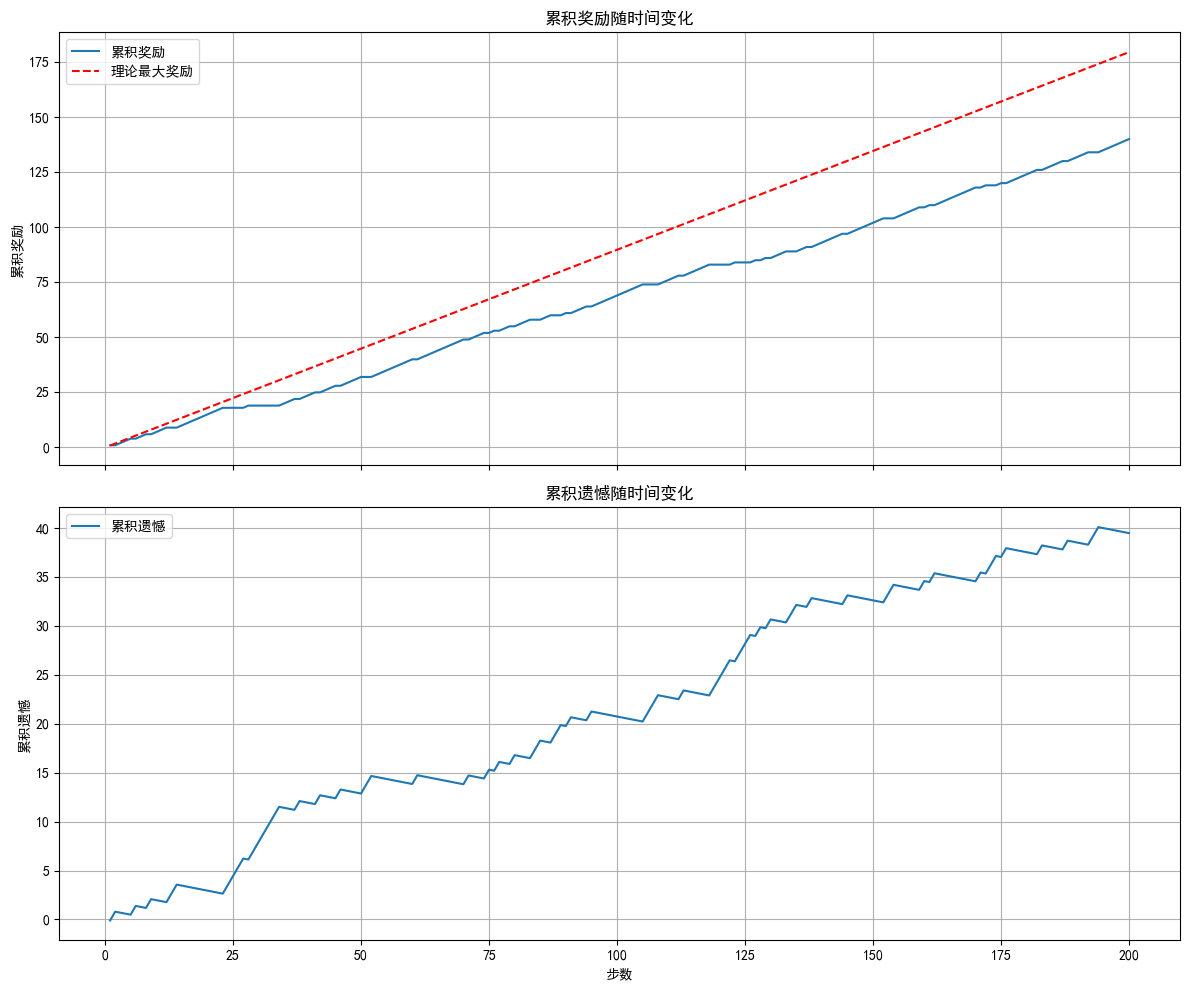


累积奖励: 140.0
累积遗憾: 39.48
每个臂的选择次数: [20 21 15 35 18  7 36 21  7 20]
每个臂的平均奖励: [0.65   0.7143 0.5333 0.8857 0.6111 0.1429 0.8889 0.7143 0.1429 0.65  ]


In [5]:
def optimized_ucb(bandit, c=1.5): 
    total_pulls = np.sum(bandit.counts)
    if total_pulls < bandit.K:  # 确保每个臂至少尝试一次
        return total_pulls
    
    ucb_values = bandit.values + c * np.sqrt(np.log(total_pulls + 1) / (bandit.counts + 1e-10))
    return np.argmax(ucb_values)

# 使用
bandit.reset_stats()
for i in range(200):
    arm = optimized_ucb(bandit, c=1.5)
    reward = bandit.step(arm)
bandit.plot_performance()
print(f"\n累积奖励: {bandit.cumulative_reward}")    
print(f"累积遗憾: {bandit.cumulative_regret:.2f}")    
print(f"每个臂的选择次数: {bandit.counts}")    
print(f"每个臂的平均奖励: {np.round(bandit.values, 4)}")

开始UCB参数网格搜索...
测试 c=0.50...
  c=0.50: 平均奖励=157.8 ± 6.8
测试 c=1.00...
  c=1.00: 平均奖励=148.7 ± 4.9
测试 c=1.50...
  c=1.50: 平均奖励=143.4 ± 4.8
测试 c=2.00...
  c=2.00: 平均奖励=139.4 ± 4.9
测试 c=2.50...
  c=2.50: 平均奖励=137.9 ± 5.3
测试 c=3.00...
  c=3.00: 平均奖励=133.5 ± 5.6
测试 c=4.00...
  c=4.00: 平均奖励=131.3 ± 5.1
测试 c=5.00...
  c=5.00: 平均奖励=130.4 ± 6.0

网格搜索结果:
最优c值: 0.5
最优平均奖励: 157.8
最优平均遗憾: 26.4


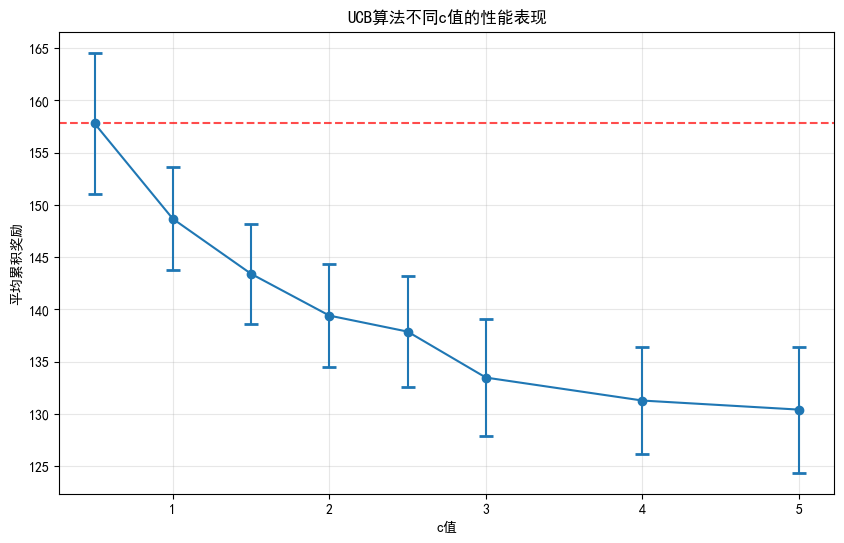

In [6]:
def grid_search_ucb(bandit_original, c_values, num_trials=20, total_steps=200):
    """
    网格搜索最优c值
    
    参数:
        bandit_original: 原始老虎机实例
        c_values: 要测试的c值列表
        num_trials: 每个c值的试验次数
        total_steps: 每次试验的步数
    """
    results = {}
    
    for c in c_values:
        print(f"测试 c={c:.2f}...")
        total_rewards = []
        total_regrets = []
        
        for trial in range(num_trials):
            # 创建新的老虎机实例（相同概率分布）
            bandit = BernoulliBandit(bandit_original.K, seed=114514 + trial)
            bandit.probs = bandit_original.probs.copy()  # 保持相同概率
            
            # 运行UCB
            for t in range(total_steps):
                if t < bandit.K:  # 初始阶段：每个臂至少试一次
                    arm = t
                else:
                    # UCB选择
                    ucb_values = []
                    for a in range(bandit.K):
                        exploration = c * np.sqrt(np.log(t + 1) / (bandit.counts[a] + 1e-10))
                        ucb_values.append(bandit.values[a] + exploration)
                    arm = np.argmax(ucb_values)
                
                reward = bandit.step(arm)
            
            total_rewards.append(bandit.cumulative_reward)
            total_regrets.append(bandit.cumulative_regret)
        
        # 统计结果
        results[c] = {
            'avg_reward': np.mean(total_rewards),
            'std_reward': np.std(total_rewards),
            'avg_regret': np.mean(total_regrets),
            'std_regret': np.std(total_regrets),
            'min_reward': np.min(total_rewards),
            'max_reward': np.max(total_rewards)
        }
        
        print(f"  c={c:.2f}: 平均奖励={results[c]['avg_reward']:.1f} ± {results[c]['std_reward']:.1f}")
    
    return results

# 定义要测试的c值范围
c_values = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0]

# 运行网格搜索
print("开始UCB参数网格搜索...")
search_results = grid_search_ucb(bandit, c_values, num_trials=15)

# 找到最优c值
best_c = max(search_results.items(), key=lambda x: x[1]['avg_reward'])[0]
best_result = search_results[best_c]

print(f"\n网格搜索结果:")
print(f"最优c值: {best_c}")
print(f"最优平均奖励: {best_result['avg_reward']:.1f}")
print(f"最优平均遗憾: {best_result['avg_regret']:.1f}")

# 可视化结果
c_list = list(search_results.keys())
rewards = [search_results[c]['avg_reward'] for c in c_list]
stds = [search_results[c]['std_reward'] for c in c_list]

plt.figure(figsize=(10, 6))
plt.errorbar(c_list, rewards, yerr=stds, fmt='o-', capsize=5, capthick=2)
plt.xlabel('c值')
plt.ylabel('平均累积奖励')
plt.title('UCB算法不同c值的性能表现')
plt.grid(True, alpha=0.3)
plt.axhline(y=best_result['avg_reward'], color='r', linestyle='--', alpha=0.7)
plt.show()

In [7]:
# 发现c=0~0.5区间表现好，进行精细搜索
fine_c_values = np.arange(0.01, 0.5, 0.01)  
fine_results = grid_search_ucb(bandit, fine_c_values, num_trials=20)

# 找到精确的最优c值
best_fine_c = max(fine_results.items(), key=lambda x: x[1]['avg_reward'])[0]
print(f"最优c值为：{best_fine_c}")

测试 c=0.01...
  c=0.01: 平均奖励=166.2 ± 8.6
测试 c=0.02...
  c=0.02: 平均奖励=166.2 ± 7.9
测试 c=0.03...
  c=0.03: 平均奖励=167.8 ± 6.8
测试 c=0.04...
  c=0.04: 平均奖励=167.7 ± 6.7
测试 c=0.05...
  c=0.05: 平均奖励=167.6 ± 6.5
测试 c=0.06...
  c=0.06: 平均奖励=167.4 ± 6.3
测试 c=0.07...
  c=0.07: 平均奖励=168.8 ± 5.7
测试 c=0.08...
  c=0.08: 平均奖励=167.1 ± 7.1
测试 c=0.09...
  c=0.09: 平均奖励=167.3 ± 7.2
测试 c=0.10...
  c=0.10: 平均奖励=166.6 ± 7.8
测试 c=0.11...
  c=0.11: 平均奖励=165.2 ± 9.1
测试 c=0.12...
  c=0.12: 平均奖励=166.2 ± 9.1
测试 c=0.13...
  c=0.13: 平均奖励=167.2 ± 7.5
测试 c=0.14...
  c=0.14: 平均奖励=166.2 ± 8.3
测试 c=0.15...
  c=0.15: 平均奖励=166.8 ± 7.2
测试 c=0.16...
  c=0.16: 平均奖励=167.0 ± 6.7
测试 c=0.17...
  c=0.17: 平均奖励=167.1 ± 7.6
测试 c=0.18...
  c=0.18: 平均奖励=167.0 ± 7.7
测试 c=0.19...
  c=0.19: 平均奖励=168.1 ± 7.6
测试 c=0.20...
  c=0.20: 平均奖励=167.6 ± 5.7
测试 c=0.21...
  c=0.21: 平均奖励=167.9 ± 6.9
测试 c=0.22...
  c=0.22: 平均奖励=168.7 ± 5.8
测试 c=0.23...
  c=0.23: 平均奖励=169.3 ± 5.6
测试 c=0.24...
  c=0.24: 平均奖励=168.9 ± 5.8
测试 c=0.25...
  c=0.25: 平均奖励=168.8 ± 5.8


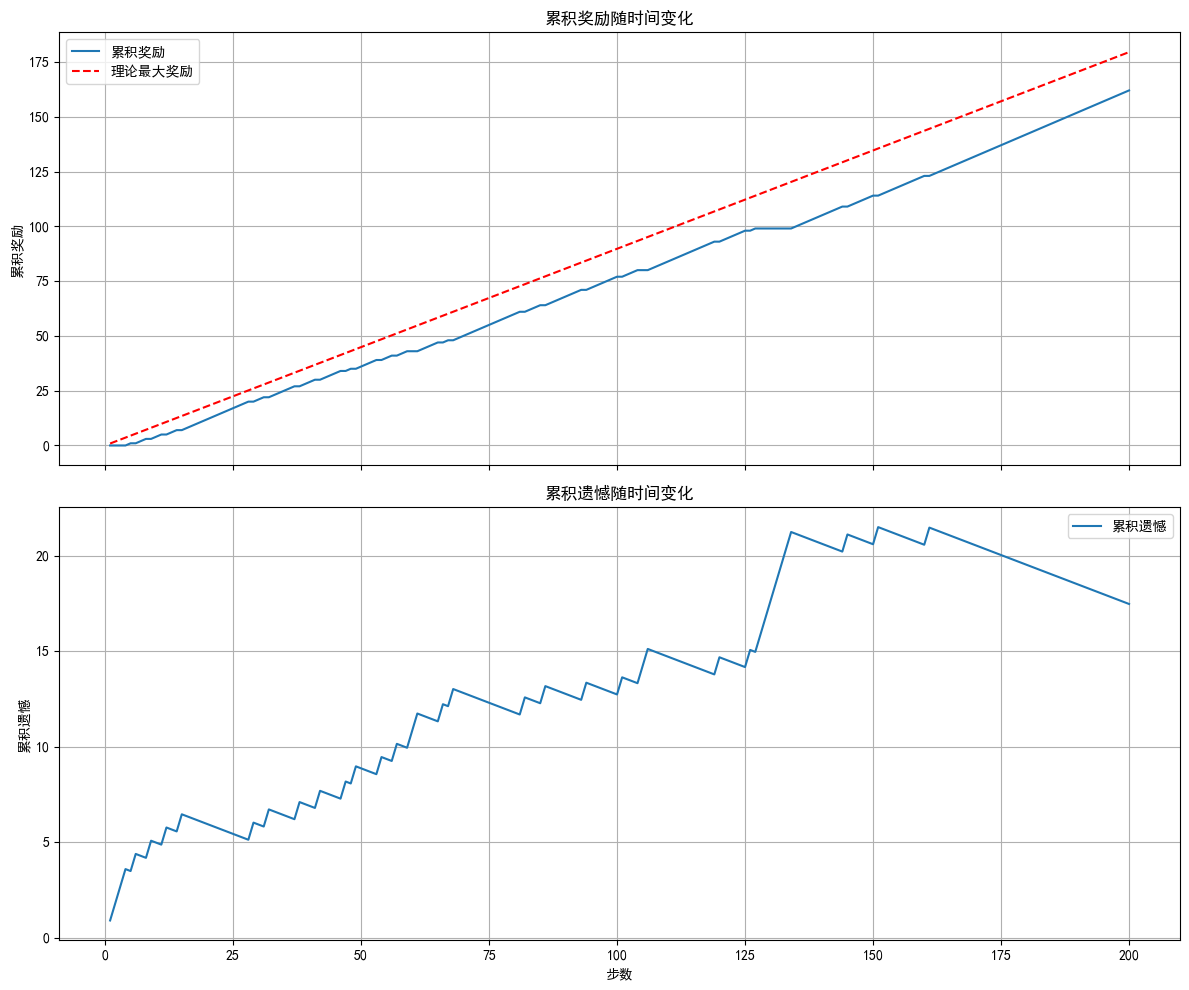


累积奖励: 162.0
累积遗憾: 17.48
每个臂的选择次数: [ 1  1  1  1  7  1 68 96  1 23]
每个臂的平均奖励: [0.     0.     0.     0.     0.5714 0.     0.9412 0.8021 0.     0.7391]


In [8]:
bandit.reset_stats()
for i in range(200):
    arm = optimized_ucb(bandit, c=0.23)
    reward = bandit.step(arm)
bandit.plot_performance()
print(f"\n累积奖励: {bandit.cumulative_reward}")    
print(f"累积遗憾: {bandit.cumulative_regret:.2f}")    
print(f"每个臂的选择次数: {bandit.counts}")    
print(f"每个臂的平均奖励: {np.round(bandit.values, 4)}")